# 8 Node TSP Example

The traveling salesman problem is a longstanding example of the difficulty found in solving combinatorial problems. Despite the simple explanation of the problem, a polynomial-time solution is not known to exist. This example takes 8 random points on the upper right quadrant (30, 30) of the Cartesian plane, calculates the Euclidian distance between them and formulates a sequential model (visit node $x_i$ first, node $x_j$ second and so forth ).

In [1]:
import os.path
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qci_client import QciClient

In [2]:
def x(a, b, N=4):
    return (a) * N + (b)

def tsp_obj_const(distance_matrix, scaled=False):
    N = len(distance_matrix)
    A1 = np.zeros((N, N ** 2 + 1))
    B01 = np.zeros((N, 1))
    for i in range(N):
        A1[i, i * N: N * (i + 1)] = np.ones((1, N))
    A01 = A1[0:, 0: N * N]
    A1[:, -1] = -1
    B01[:] = 1
    A2 = np.hstack([np.identity(N) for i in range(N)])
    A02 = A2
    A2 = np.hstack([A2, -np.ones((N, 1))])
    B02 = np.ones((N, 1))
    A = np.vstack([A1, A2])
    A0 = np.vstack([A01, A02])
    B = np.vstack([B01, B02])
    obj = np.zeros((N * N, N * N))
    for u in range(N):
        for v in range(N):
            if u != v:
                for j in range(N):
                    obj[(x(u, j, N), x(v, (j + 1) % N, N))] += (
                            distance_matrix[u][v] / 2
                    )
                    obj[(x(v, (j + 1) % N, N), x(u, j, N))] += (
                            distance_matrix[u][v] / 2
                    )
    if scaled:
        Amean = A.mean()
    else:
        Amean = 1
    print('TSP constraint scaling factor: ', 1 / Amean)
    return obj, A0 / Amean, (B / Amean).reshape((2*N,))


In [3]:
def make_file(data, file_type, file_name, **kwargs):
    upload_file = {"data": data, "file_type": file_type, "file_name": file_name}
    upload_file.update(kwargs)
    return upload_file

In [4]:
def dist(coord1, coord2):
    return np.sqrt(np.sum(np.power(coord1-coord2, 2), axis=1))

In [5]:
def plot_route(coords, solution, N):
    pairs = []
    order = [None for i in range(N)]
    for i in range(N):
        for j in range(N):
            if solution[i*N + j] == 1:
                order[j] = i
    for i in range(N):
        u = order[i-1]
        v = order[i]
        if u is None or v is None:
            continue
        pt1 = coords[u, :]
        pt2 = coords[v, :]
        x = [pt1[0], pt2[0]]
        y = [pt1[1], pt2[1]]
        plt.plot(x, y, "r-")
    plt.scatter(coords[:,0], coords[:, 1], c="k", marker="o")

In [6]:
N = 8
np.random.seed(N)
coords = np.random.randint(1, 30, (N, 2))
distance_matrix = [dist(coords, coords[i]) for i in range(N)]

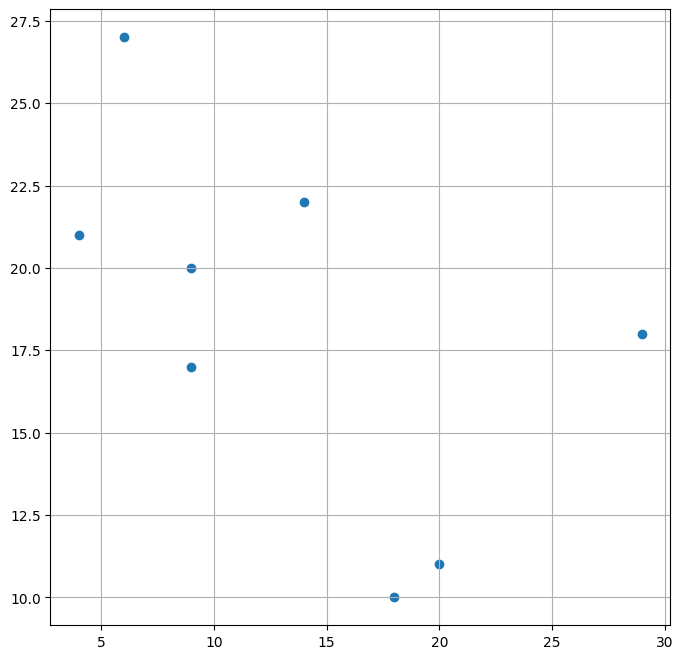

In [7]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(coords[:,0], coords[:, 1])
plt.grid()

In [8]:
objective, lhs, rhs = tsp_obj_const(distance_matrix, scaled=True)

TSP constraint scaling factor:  9.285714285714285


In [9]:
client = QciClient()

In [10]:
objective_data = []
for i in range(objective.shape[0]):
    for j in range(objective.shape[1]):
        objective_data.append({"i": i, "j":j, "val": objective[i, j]})
lhs_data = []
for i in range(lhs.shape[0]):
    for j in range(lhs.shape[1]):
        lhs_data.append({"i": i, "j": j, "val": lhs[i, j]})
rhs_data = rhs.tolist()
obj_file = make_file(objective_data, "objective", "tsp_objective.json", num_variables=objective.shape[0])
lhs_file = make_file(lhs_data, "constraints", "tsp_lhs.json", num_variables=lhs.shape[1], num_constraints=lhs.shape[0])
rhs_file = make_file(rhs_data, "rhs", "tsp_rhs.json", num_constraints=lhs.shape[0])

In [11]:
obj_file_id = client.upload_file(data=obj_file)["file_id"]
lhs_file_id = client.upload_file(data=lhs_file)["file_id"]
rhs_file_id = client.upload_file(data=rhs_file)["file_id"]

In [12]:
job_body = client.build_job_body(job_type="sample-constraint", objective_file_id=obj_file_id, 
                                 constraints_file_id=lhs_file_id, rhs_file_id=rhs_file_id, job_params={
                                     "sampler_type": "eqc1",
                                     "n_samples": 5, 
                                     "alpha": 1
                                 })

In [13]:
job_response = client.process_job(job_type="sample-constraint", job_body=job_body)

Job submitted job_id='6579f30766705e945c78fc0d'-: 2023/12/13 11:08:09
RUNNING: 2023/12/13 11:08:13
COMPLETED: 2023/12/13 11:09:26


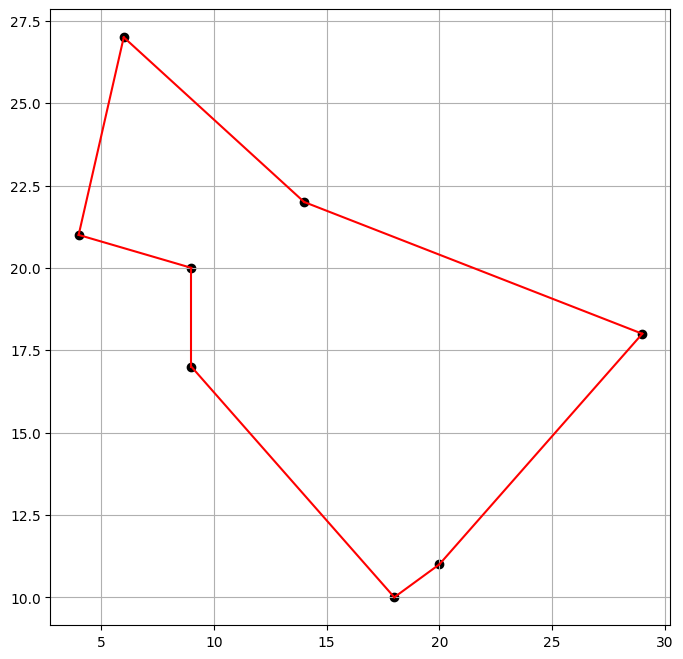

In [14]:
fig = plt.figure(figsize=(8, 8))
plot_route(coords, job_response["results"]["samples"][0], N)
plt.grid()